In [14]:
try: 
    if manager == 1: 
        print("Manager Mode: ON")
except:
    print("Manager Mode: OFF")
    %run s0_config.ipynb 
    import scanpy as sc 
    import numpy as np 
    import pandas as pd 

Manager Mode: OFF
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


In [15]:
adata = sc.read(check_point_s2)   

In [16]:
# Modified Function to Calculate Resolutions
def calculate_resolutions(adata, method="pca", true_label="cell_type", start_res=1, jump_res=0.01):
    target_cluster = pd.unique(adata.obs[true_label])
    n_clusters = []
    n_dict = {}

    res = start_res
    threshold = 0

    while True:
        res_key = f"leiden_{method}_{str(float(np.round(res, 3)))}"
        print("res_key:", res_key)
        sc.tl.leiden(adata, key_added=res_key, resolution=res)
        n_clusters.append(adata.obs[res_key].nunique())
        n_dict[res_key] = res

        if adata.obs[res_key].nunique() == len(target_cluster):
            if threshold == 0:
                break
        elif adata.obs[res_key].nunique() < len(target_cluster):
            res += 0.25
        else:
            res -= 0.25

        # Add a stopping condition to prevent infinite loops
        if res <= 0 or res > 10:
            break

    return adata, n_dict

In [17]:
adata.obs['cell_type_short'] = adata.obs['cell_type'].str[:8]

#### PCA 

computing PCA
    with n_comps=50
    finished (0:00:08)


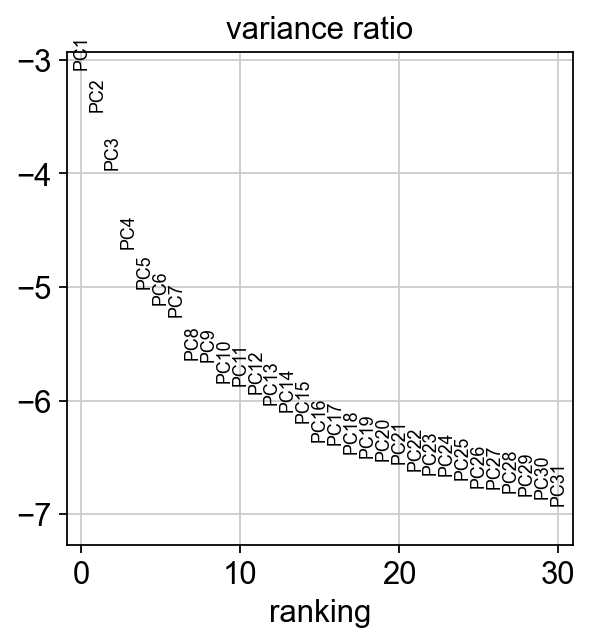

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [18]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, use_rep='X_pca')


In [19]:
# Initialize DataFrame to store results
results_df = pd.DataFrame(columns=['version', 'resolution', 'silhouette_score', 'ari', 'purity'])

In [20]:
# Iterate for Different Versions
for i in range(10):
    # Adjust starting resolution and jump for variation
    start_res = 1 + i * 0.05
    jump_res = 0.01 + i * 0.001
    adata, n_dict_pca = calculate_resolutions(adata, method="pca", true_label="cell_type", start_res=start_res, jump_res=jump_res)
    best_pca = list(n_dict_pca.keys())[-2]
    current_key = best_pca

    from sklearn.metrics import silhouette_score, adjusted_rand_score
    from sklearn.metrics.cluster import contingency_matrix

    silhouette_avg = silhouette_score(adata.obsm['X_pca'], adata.obs[current_key])
    ari = adjusted_rand_score(adata.obs['cell_type'], adata.obs[current_key])
    cm = contingency_matrix(adata.obs['cell_type'], adata.obs[current_key])
    purity = np.sum(np.amax(cm, axis=0)) / np.sum(cm)

    # Append results to DataFrame
    results_df = results_df.append({
        'version': i + 1,
        'resolution': n_dict_pca[best_pca],
        'silhouette_score': silhouette_avg,
        'ari': ari,
        'purity': purity
    }, ignore_index=True)

    print(f"Version {i+1} completed")

res_key: leiden_pca_1.0
running Leiden clustering
    finished: found 29 clusters and added
    'leiden_pca_1.0', the cluster labels (adata.obs, categorical) (0:00:13)
res_key: leiden_pca_0.75
running Leiden clustering
    finished: found 25 clusters and added
    'leiden_pca_0.75', the cluster labels (adata.obs, categorical) (0:00:12)
res_key: leiden_pca_0.5
running Leiden clustering
    finished: found 21 clusters and added
    'leiden_pca_0.5', the cluster labels (adata.obs, categorical) (0:00:08)
res_key: leiden_pca_0.25
running Leiden clustering
    finished: found 20 clusters and added
    'leiden_pca_0.25', the cluster labels (adata.obs, categorical) (0:00:11)


AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
results_df

In [ ]:
current_key = best_pca 

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=200, facecolor="white", figsize=(14, 14))

sc.pl.umap(
    adata, 
    color=[current_key, "cell_type_short"], 
    legend_loc="on data", 
    title=[current_key, "cell_type_short"], 
    frameon=True, 
    size=50
)
print(f"Number of clusters in selected cluster key {current_key}: {adata.obs[current_key].nunique()}")


#### ICA 

In [ ]:
from sklearn.decomposition import FastICA 

In [ ]:
ica = FastICA(n_components=20, random_state=0)
ica_result = ica.fit_transform(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X)
adata.obsm['X_ica'] = ica_result 
sc.pp.neighbors(adata, use_rep='X_ica') 

In [ ]:
adata, n_dict_ica = calculate_resolutions(adata, 
                                          method="ica", 
                                          true_label = "cell_type", 
                                          start_res = 0.5,
                                          jump_res = 0.01)  
best_ica = list(n_dict_ica.keys())[-2]  

In [ ]:
current_key = best_ica 

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=200, facecolor="white", figsize=(14, 14))

sc.pl.umap(
    adata, 
    color=[current_key, "cell_type_short"], 
    legend_loc="on data", 
    title=[current_key, "cell_type_short"], 
    frameon=True, 
    size=50
)
print(f"Number of clusters in selected cluster key {current_key}: {adata.obs[current_key].nunique()}")


#### Auteoncoder  

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

input_dim = adata.X.shape[1]
encoding_dim = 50

input_layer = layers.Input(shape=(input_dim,))
encoder = layers.Dense(encoding_dim, activation="relu")(input_layer)
decoder = layers.Dense(input_dim, activation="sigmoid")(encoder)

autoencoder = tf.keras.Model(input_layer, decoder)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(adata.X, adata.X, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

encoder_model = tf.keras.Model(input_layer, encoder)
encoded_data = encoder_model.predict(adata.X)

adata.obsm["X_autoencoder"] = encoded_data

sc.pp.neighbors(adata, use_rep='X_autoencoder')


In [ ]:
adata, n_dict_autoencoder = calculate_resolutions(adata, 
                                                  method="autoencoder", 
                                                  true_label = "cell_type", 
                                                  start_res = 0.95,
                                                  jump_res = 0.01)  
best_autoencoder = list(n_dict_autoencoder.keys())[-3]   

In [ ]:
best_autoencoder = list(n_dict_autoencoder.keys())[-3]   

In [ ]:
current_key = best_autoencoder 

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=200, facecolor="white", figsize=(14, 14))

sc.pl.umap(
    adata, 
    color=[current_key, "cell_type_short"], 
    legend_loc="on data", 
    title=[current_key, "cell_type_short"], 
    frameon=True, 
    size=50
)
print(f"Number of clusters in selected cluster key {current_key}: {adata.obs[current_key].nunique()}")


#### PCA + Auteoncoder  

In [ ]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# Normalize PCA-reduced data
scaler = StandardScaler()
pca_data_normalized = scaler.fit_transform(adata.obsm['X_pca'][:, :30])


input_dim = pca_data_normalized.shape[1]
encoding_dim = 50

input_layer = layers.Input(shape=(input_dim,))
encoder = layers.Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = layers.Dense(encoding_dim // 2, activation="relu")(encoder)
decoder = layers.Dense(input_dim, activation="sigmoid")(encoder)

autoencoder = tf.keras.Model(input_layer, decoder)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(pca_data_normalized, pca_data_normalized, epochs=200, batch_size=256, shuffle=True, validation_split=0.2)

encoder_model = tf.keras.Model(input_layer, encoder)
encoded_data = encoder_model.predict(pca_data_normalized)

adata.obsm["X_combined"] = encoded_data



In [ ]:
adata, n_dict_combined = calculate_resolutions(adata, 
                                               method="combined", 
                                               true_label="cell_type", 
                                               start_res=0.32, 
                                               jump_res=0.1)  
best_combined = list(n_dict_combined.keys())[-2]   
current_key = best_combined 

In [ ]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=200, facecolor="white", figsize=(14, 14))

sc.pl.umap(
    adata, 
    color=[current_key, "cell_type_short"], 
    legend_loc="on data", 
    title=[current_key, "cell_type_short"], 
    frameon=True, 
    size=100
)
print(f"Number of clusters in selected cluster key {current_key}: {adata.obs[current_key].nunique()}")


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix


silhouette_avg = silhouette_score(adata.obsm['X_combined'], adata.obs[current_key])
print("Silhouette Score: ", silhouette_avg)

ari = adjusted_rand_score(adata.obs['cell_type'], adata.obs[current_key])
print("Adjusted Rand Index: ", ari)

cm = contingency_matrix(adata.obs['cell_type'], adata.obs[current_key])
purity = np.sum(np.amax(cm, axis=0)) / np.sum(cm)
print("Cluster Purity: ", purity)
